## Danh mục:


1.   Import thư viện
2.   Kiểm tra số lượng giá trị thiếu
3.   Xử lý missing values bằng EMImpute
4.   Kiểm tra lại dataset sau khi xử lý missing values
5.   Loại bỏ ouliers, nhiễu
6.   Trực quan hóa dữ liệu sau tiền xử lý





# Import thư viện

In [56]:
# import thư viện
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns



# Kiểm tra số lượng giá trị thiếu

In [57]:
df = pd.read_csv("data.csv")

# Kiểm tra số lượng giá trị thiếu
missing_summary = df.isnull().sum()
print(missing_summary)

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


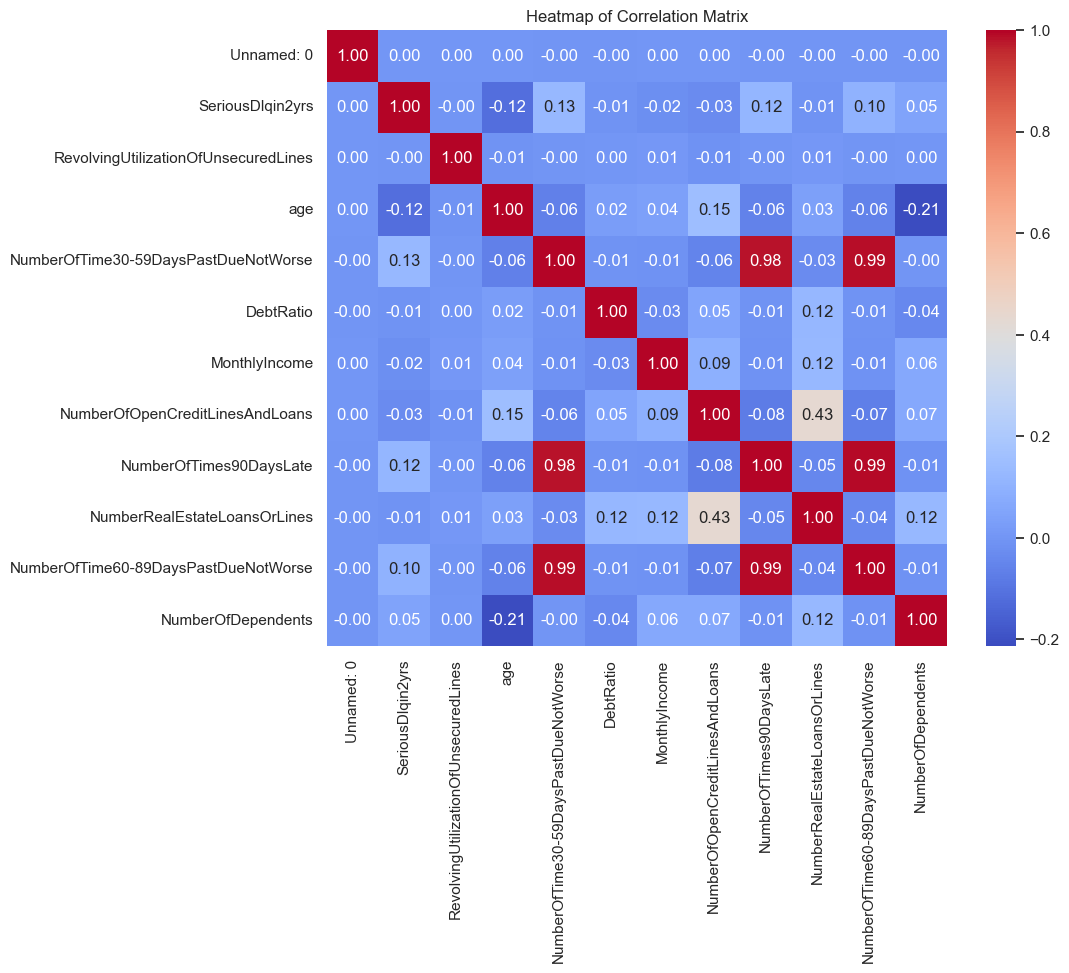

In [58]:
data = pd.read_csv("data.csv")

correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Correlation Matrix")
plt.show()

# Xử lý missing values bằng EMImpute

In [59]:
class EMImputer:
    def __init__(self, max_iter=10, tol=1e-4, random_state=42):
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(self.random_state)

    def initialize(self, data):
        """Khởi tạo dữ liệu và điền giá trị ban đầu."""
        self.data = data.copy()
        self.missing_mask = np.isnan(self.data)

        # Điền giá trị ban đầu bằng trung bình
        initial_imputer = SimpleImputer(strategy="mean")
        self.data[self.missing_mask] = initial_imputer.fit_transform(self.data)[self.missing_mask]

    def m_step(self):
        """Bước M: Tính toán các tham số trung bình và hiệp phương sai."""
        self.mean = np.nanmean(self.data, axis=0)
        self.cov = np.cov(self.data, rowvar=False, bias=True)

    def e_step(self):
        """Bước E: Ước lượng lại giá trị bị thiếu."""
        for i in range(self.data.shape[0]):
            missing_indices = np.where(self.missing_mask[i])[0]
            observed_indices = np.where(~self.missing_mask[i])[0]

            if len(missing_indices) > 0:
                observed_values = self.data[i, observed_indices]

                # Tách các ma trận hiệp phương sai
                cov_oo = self.cov[np.ix_(observed_indices, observed_indices)]
                cov_om = self.cov[np.ix_(observed_indices, missing_indices)]

                mean_m = self.mean[missing_indices]
                mean_o = self.mean[observed_indices]

                # Ước lượng giá trị bị thiếu
                conditional_mean = mean_m + cov_om.T @ np.linalg.inv(cov_oo) @ (observed_values - mean_o)
                
                self.data[i, missing_indices] = conditional_mean

    def em_algorithm(self):
        """Chạy vòng lặp thuật toán EM."""
        for iteration in range(self.max_iter):
            old_data = self.data.copy()

            # Bước M
            self.m_step()

            # Bước E
            self.e_step()

            # Kiểm tra hội tụ
            if np.linalg.norm(self.data - old_data) < self.tol:
                print(f"EM converged after {iteration + 1} iterations.")
                break

    def fit_transform(self, data):
        """Khởi chạy toàn bộ quy trình EM để điền giá trị thiếu."""
        self.initialize(data)
        self.em_algorithm()
        return self.data


In [60]:
data = pd.read_csv("data.csv")

columns_to_use = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTimes90DaysLate",
    "age",
    "SeriousDlqin2yrs",
    "MonthlyIncome",
    "NumberOfDependents"
]

selected_data = data[columns_to_use].values

# Áp dụng EM để nội suy
em_imputer = EMImputer(max_iter=10, tol=1e-4, random_state=42)
imputed_data = em_imputer.fit_transform(selected_data)

# Chuyển kết quả thành DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=columns_to_use)

# Làm tròn và chuyển "NumberOfDependents" về kiểu số nguyên
imputed_data_df["NumberOfDependents"] = imputed_data_df["NumberOfDependents"].round().astype(int)

# Cập nhật dữ liệu gốc
data[columns_to_use] = imputed_data_df[columns_to_use]

# Lưu kết quả
data.to_csv("em_imputed_data.csv", index=False)
print("Dữ liệu sau khi nội suy bằng EM đã được lưu vào file 'em_imputed_data.csv'.")


Dữ liệu sau khi nội suy bằng EM đã được lưu vào file 'em_imputed_data.csv'.


Sử dụng Đồ thị Histogram để kiểm tra khả năng nội suy của EM

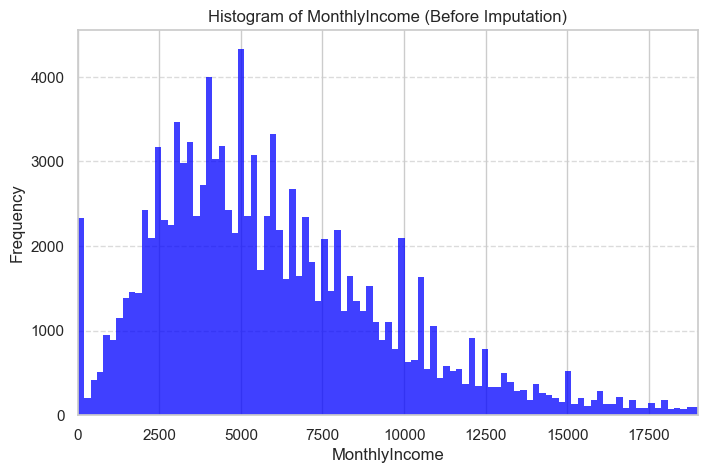

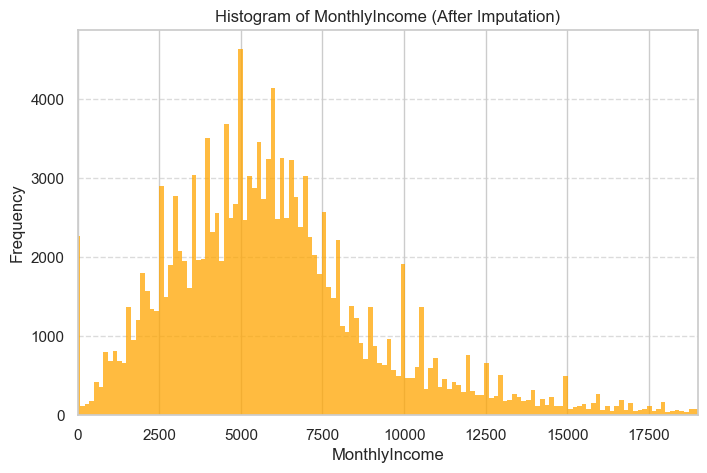

In [61]:
data = pd.read_csv("data.csv")

# Vẽ histogram trước khi nội suy
plt.figure(figsize=(8, 5))
sns.histplot(data['MonthlyIncome'], color="blue")
plt.title("Histogram of MonthlyIncome (Before Imputation)")
plt.xlabel("MonthlyIncome")
plt.ylabel("Frequency")
plt.xlim(0, 19000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

em_data = pd.read_csv("em_imputed_data.csv")
# Vẽ histogram sau khi nội suy
plt.figure(figsize=(8, 5))
sns.histplot(em_data['MonthlyIncome'], color="orange")
plt.title("Histogram of MonthlyIncome (After Imputation)")
plt.xlabel("MonthlyIncome")
plt.ylabel("Frequency")
plt.xlim(0, 19000) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Kiểm tra lại dataset sau khi xử lý missing values

In [62]:
df = pd.read_csv("em_imputed_data.csv")

missing_summary = df.isnull().sum()
print(missing_summary)

Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


# Loại bỏ ouliers, nhiễu

In [63]:
data = pd.read_csv("em_imputed_data.csv")
# Lay cac cot can thiet
columns_to_keep = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate',
    'age',
    'SeriousDlqin2yrs'
]
filtered_data = data[columns_to_keep]

#Loc du lieu
filtered_data = filtered_data[
    (filtered_data['RevolvingUtilizationOfUnsecuredLines'].between(0, 1)) &
    (filtered_data['DebtRatio'].between(0, 1)) &
    (filtered_data['NumberOfTimes90DaysLate'] < 8) &
    (filtered_data['age'].between(20, 85))
]


# Xoa instances co 2,5% gia tri cao nhat, thap nhat
for col in columns_to_keep:
    lower_bound = filtered_data[col].quantile(0.025)
    upper_bound = filtered_data[col].quantile(0.975)
    filtered_data = filtered_data[
        (filtered_data[col] >= lower_bound) &
        (filtered_data[col] <= upper_bound)
    ]


filtered_data.to_csv('data_preprocessed.csv', index=False)


# Trực quan hóa dữ liệu sau tiền xử lý

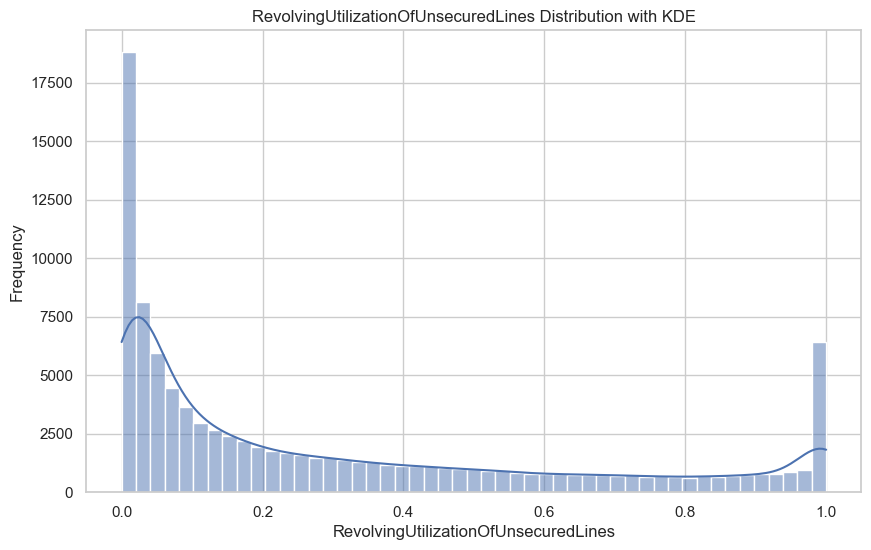

Description for RevolvingUtilizationOfUnsecuredLines:
 count    96407.000000
mean         0.301681
std          0.327363
min          0.000000
25%          0.032690
50%          0.156580
75%          0.505692
max          1.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64 



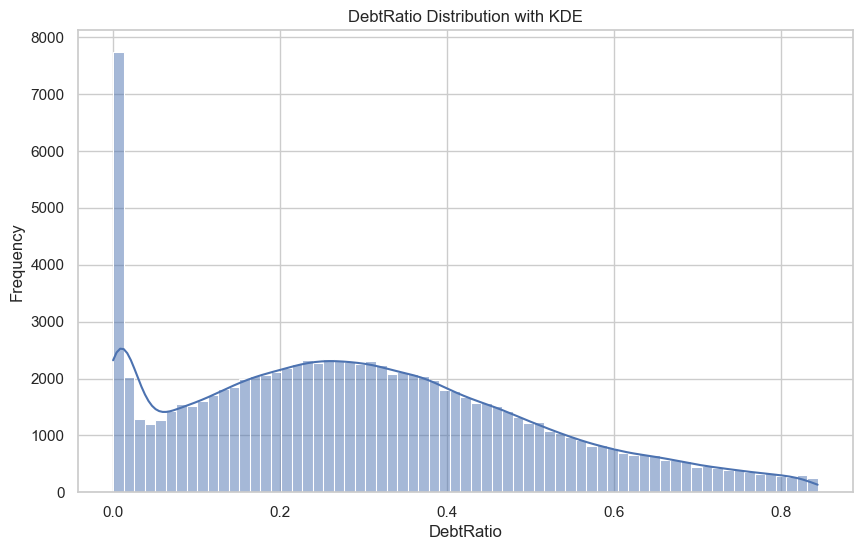

Description for DebtRatio:
 count    96407.000000
mean         0.301164
std          0.202382
min          0.000000
25%          0.144965
50%          0.284026
75%          0.433950
max          0.843697
Name: DebtRatio, dtype: float64 



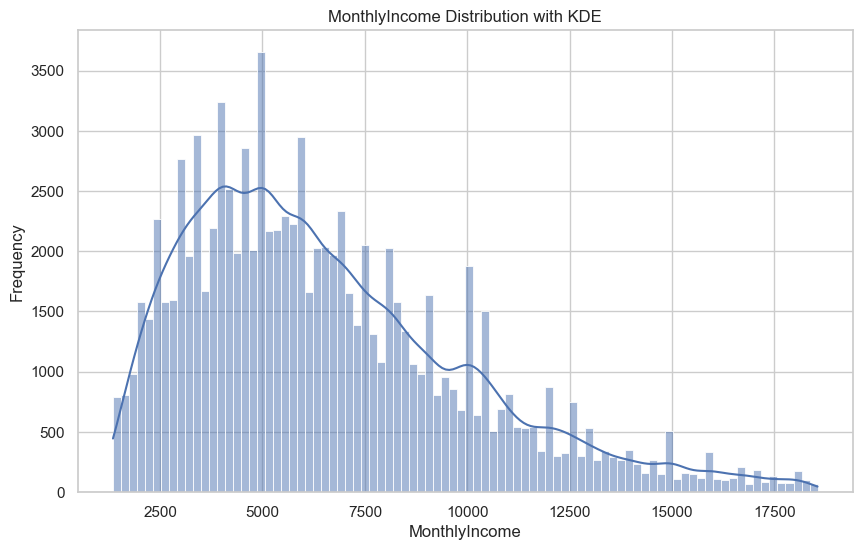

Description for MonthlyIncome:
 count    96407.000000
mean      6568.255211
std       3424.129328
min       1350.000000
25%       4000.000000
50%       5907.606720
75%       8500.000000
max      18553.000000
Name: MonthlyIncome, dtype: float64 



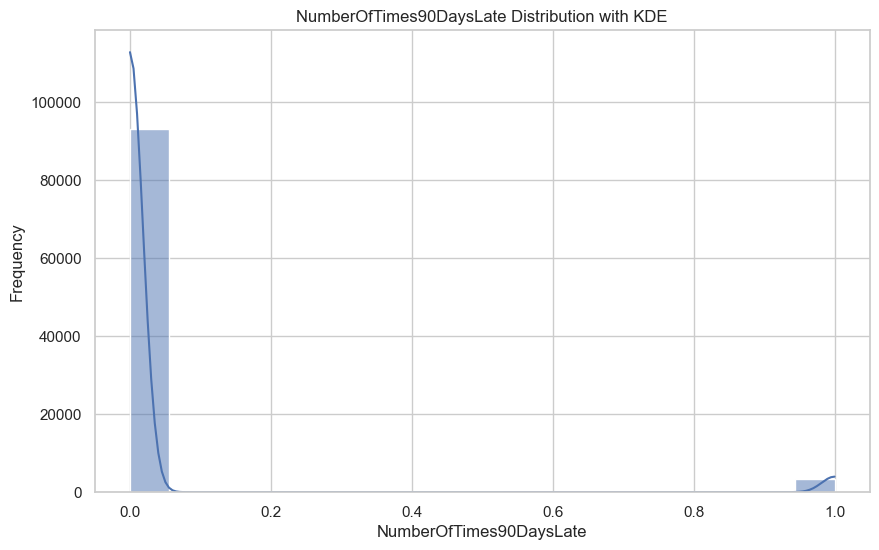

Description for NumberOfTimes90DaysLate:
 count    96407.000000
mean         0.034105
std          0.181501
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: NumberOfTimes90DaysLate, dtype: float64 



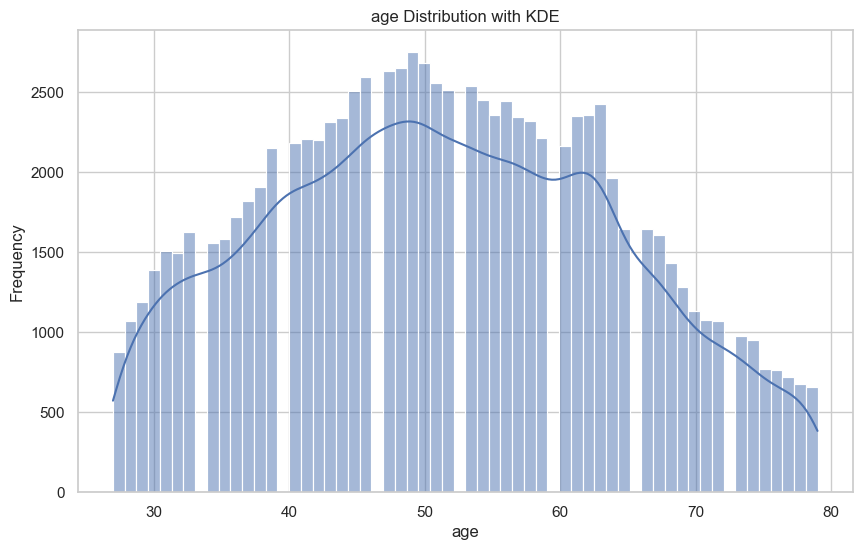

Description for age:
 count    96407.000000
mean        51.338865
std         12.801838
min         27.000000
25%         41.000000
50%         51.000000
75%         61.000000
max         79.000000
Name: age, dtype: float64 



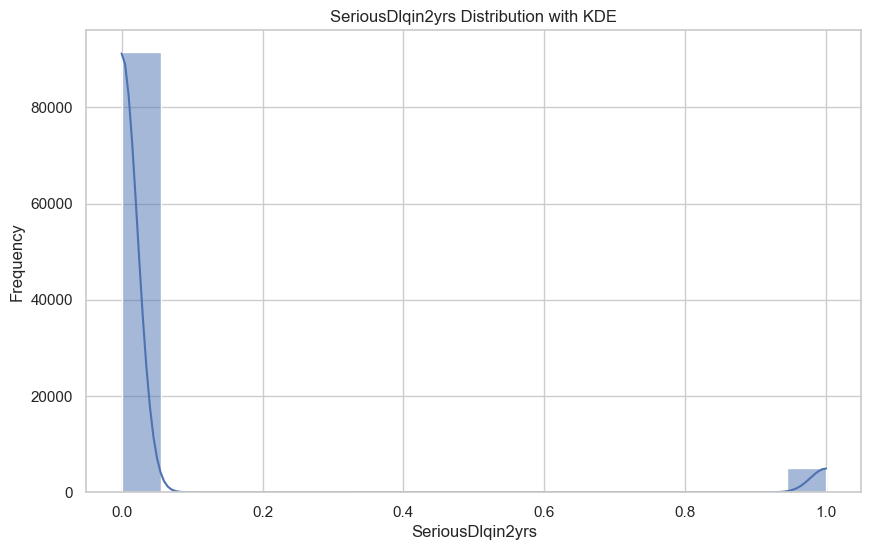

Description for SeriousDlqin2yrs:
 count    96407.000000
mean         0.051283
std          0.220575
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64 



In [64]:
data = pd.read_csv("data_preprocessed.csv")
# Mo ta du lieu
sns.set(style="whitegrid")

columns_to_visualize = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'age'
]

def plot_histogram_with_kde_and_describe(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'{column_name} Distribution with KDE')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

    # Describe the column
    description = df[column_name].describe()
    print(f"Description for {column_name}:\n", description, "\n")


# Plot and describe each column
for column in columns_to_keep:
    plot_histogram_with_kde_and_describe(data, column)

In [65]:
data["NumberOfTimes90DaysLate"].value_counts().sort_index()

NumberOfTimes90DaysLate
0.0    93119
1.0     3288
Name: count, dtype: int64